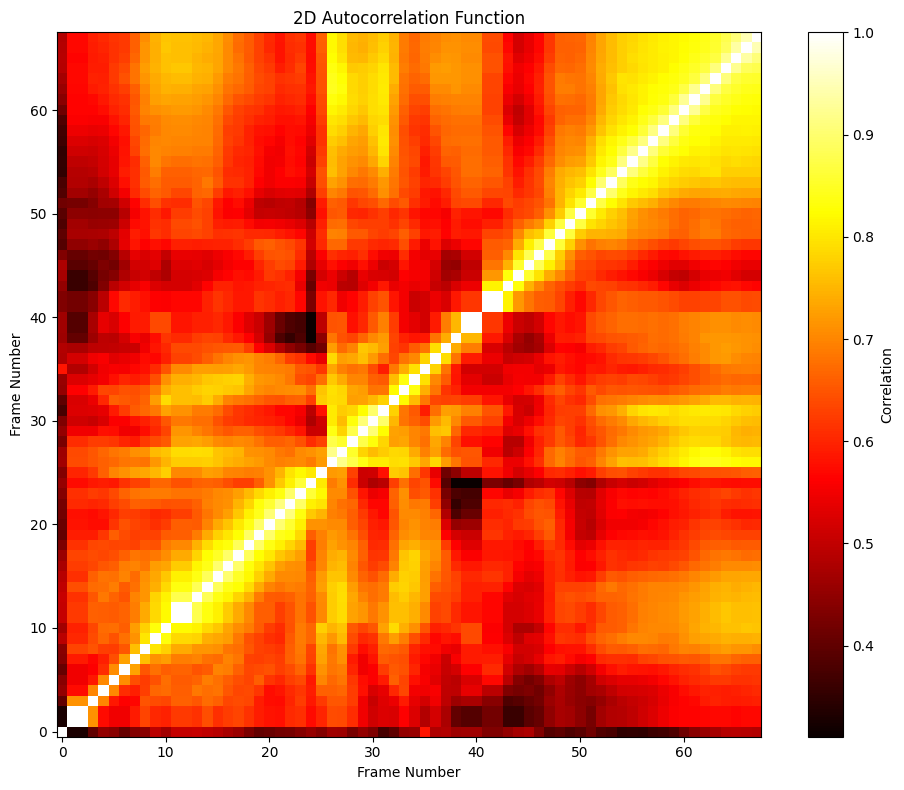

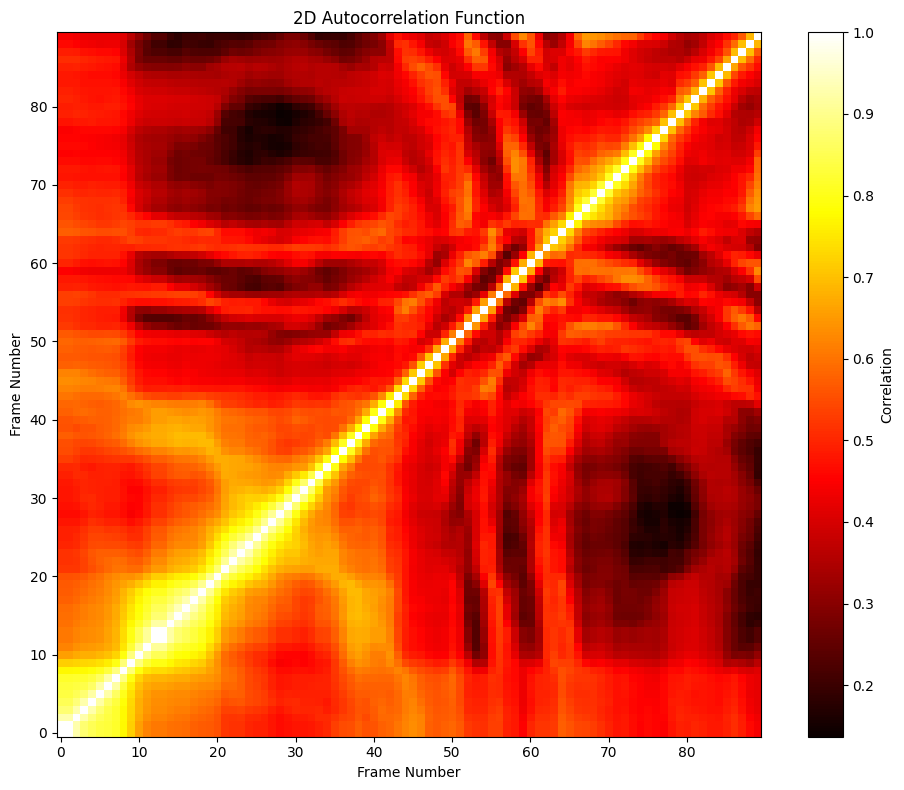

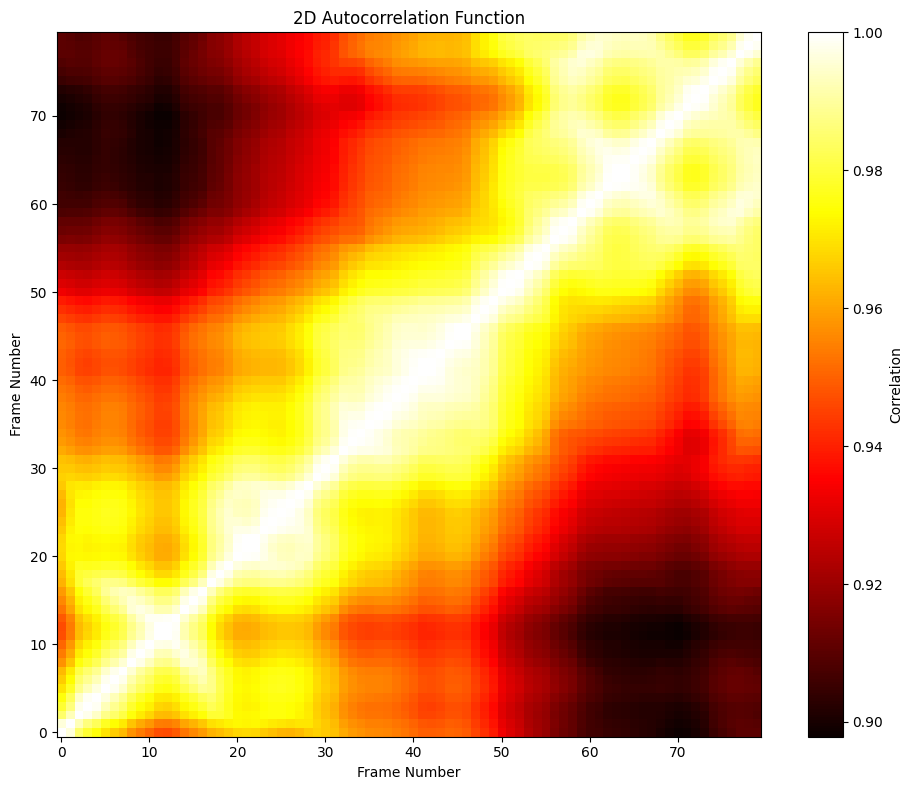

In [10]:
import av
import numpy as np
import matplotlib.pyplot as plt


def correlation(frame1, frame2):
    h, w = frame1.shape[:2]
    a = frame1.astype(np.float64)
    b = frame2.astype(np.float64)

    ma, mb = np.mean(a), np.mean(b)
    sa, sb = np.std(a), np.std(b)

    return np.sum((a - ma) * (b - mb)) / (h * w * sa * sb)


def process_video(file_path, max_frames=100):
    container = av.open(file_path)
    video = next(s for s in container.streams if s.type == 'video')

    frames = []
    for i, frame in enumerate(container.decode(video)):
        if i >= max_frames:
            break
        frames.append(frame.to_ndarray(format='gray'))

    return frames


def calculate_2d_correlation(frames):
    n = len(frames)
    corr_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            corr_matrix[i, j] = correlation(frames[i], frames[j])

    return corr_matrix


def plot_2d_correlation(corr_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='hot', origin='lower')
    plt.colorbar(label='Correlation')
    plt.title('2D Autocorrelation Function')
    plt.xlabel('Frame Number')
    plt.ylabel('Frame Number')
    plt.tight_layout()
    plt.show()


video_path = 'lr1_1.AVI'
frames = process_video(video_path)
corr_matrix = calculate_2d_correlation(frames)
plot_2d_correlation(corr_matrix)

video_path2 = 'lr1_2.AVI'
frames2 = process_video(video_path2)
corr_matrix2 = calculate_2d_correlation(frames2)
plot_2d_correlation(corr_matrix2)

video_path3 = 'lr1_3.AVI'
frames3 = process_video(video_path3)
corr_matrix3 = calculate_2d_correlation(frames3)
plot_2d_correlation(corr_matrix3)


In [15]:
# 2
import av
import numpy as np

def manual_reverse(frames):
    return frames[::-1]

def reverse_video(input_video_path, output_video_path):
    frames = []

    with av.open(input_video_path) as container:
        video_stream = container.streams.video[0]
        fps = video_stream.average_rate

        for frame in container.decode(video=0):
            frame_array = np.array(frame.to_image())
            frames.append(frame_array)

    reversed_frames = manual_reverse(frames)

    output_container = av.open(output_video_path, mode='w')
    out_stream = output_container.add_stream(
        codec_name=video_stream.codec.name,
        rate=fps
    )
    out_stream.width = video_stream.width
    out_stream.height = video_stream.height
    out_stream.pix_fmt = video_stream.pix_fmt

    for i, frame_array in enumerate(reversed_frames):
        frame = av.VideoFrame.from_ndarray(frame_array, format='rgb24')

        frame.pts = i

        packet = out_stream.encode(frame)
        output_container.mux(packet)

    output_container.mux(out_stream.encode(None))
    output_container.close()

input_video_path = 'lr1_1.AVI'
output_video_path = 'reversed_video.AVI'
reverse_video(input_video_path, output_video_path)


In [4]:
# 3
import av
import numpy as np

def merge_videos(video1_path, video2_path, output_video_path):
    def extract_frames(video_path):
        frames = []
        with av.open(video_path) as container:
            for frame in container.decode(video=0):
                frame_array = np.array(frame.to_image()) 
                frames.append(frame_array)
        return frames

    frames1 = extract_frames(video1_path)
    frames2 = extract_frames(video2_path)

    with av.open(video1_path) as container:
        video_stream = container.streams.video[0]

    output_container = av.open(output_video_path, mode='w')
    out_stream = output_container.add_stream(
        codec_name=video_stream.codec.name,
        rate=video_stream.average_rate
    )
    out_stream.width = video_stream.width
    out_stream.height = video_stream.height
    out_stream.pix_fmt = video_stream.pix_fmt

    for frame_array in frames1 + frames2:
        frame = av.VideoFrame.from_ndarray(frame_array, format='rgb24')
        packet = out_stream.encode(frame)
        output_container.mux(packet)

    output_container.mux(out_stream.encode(None))
    output_container.close()

video1_path = 'lr1_1.AVI'
video2_path = 'lr1_2.AVI'
output_video_path = 'merged_video.AVI'

merge_videos(video1_path, video2_path, output_video_path)

In [6]:
# 3a
import av
import numpy as np

def extract_frames(video_path):
    frames = []
    with av.open(video_path) as container:
        for frame in container.decode(video=0):
            frame_array = np.array(frame.to_image())
            frames.append(frame_array)
    return frames

def remove_even_columns(frame):
    return frame[:, ::2, :]

def create_black_frame(height, width):
    return np.zeros((height, width, 3), dtype=np.uint8)

def combine_frames(frame1, frame2):
    h = min(frame1.shape[0], frame2.shape[0])

    frame1 = frame1[:h]
    frame2 = frame2[:h]

    half_width = min(frame1.shape[1], frame2.shape[1])

    left_half = frame1[:, :half_width]
    right_half = frame2[:, :half_width]

    combined_frame = np.hstack((left_half, right_half))
    return combined_frame

def merge_modified_videos(video1_path, video2_path, output_video_path):
    frames1 = extract_frames(video1_path)
    frames2 = extract_frames(video2_path)

    max_frames = max(len(frames1), len(frames2))

    black_frame = create_black_frame(frames1[0].shape[0], frames1[0].shape[1])

    with av.open(video1_path) as container:
        video_stream = container.streams.video[0]

    output_container = av.open(output_video_path, mode='w')
    out_stream = output_container.add_stream(
        codec_name=video_stream.codec.name,
        rate=video_stream.average_rate
    )
    out_stream.width = video_stream.width
    out_stream.height = video_stream.height
    out_stream.pix_fmt = video_stream.pix_fmt

    for i in range(max_frames):
        frame1 = frames1[i] if i < len(frames1) else black_frame
        frame2 = frames2[i] if i < len(frames2) else black_frame

        modified_frame1 = remove_even_columns(frame1)
        modified_frame2 = remove_even_columns(frame2)

        combined_frame = combine_frames(modified_frame1, modified_frame2)

        frame = av.VideoFrame.from_ndarray(combined_frame, format='rgb24')
        packet = out_stream.encode(frame)
        output_container.mux(packet)

    output_container.mux(out_stream.encode(None))
    output_container.close()

video1_path = 'lr1_1.AVI'
video2_path = 'lr1_2.AVI'
output_video_path = 'combined_video.AVI'

merge_modified_videos(video1_path, video2_path, output_video_path)